<a href="https://colab.research.google.com/github/JoelLEMI/Test/blob/main/Local_curvarture_spindle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code accesses a Google Drive folder containing raw data from two spindles. It analyzes the curvature along each spindle and plots the results.

In [1]:
import pandas as pd
import numpy as np
import math
from scipy.interpolate import interp1d
import csv
from scipy import signal
from matplotlib import pylab as plt
from scipy.optimize import curve_fit
from scipy import stats
from PIL import Image
from pylab import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import accumulate


def rad_from_points(x1, y1, x2, y2, x3, y3):

    '''
    takes coordinates of three points, (x1, y1), (x2, y2), and (x3, y3)
    and returns the radius (r), and the coordinates of the center (xc, yc)
    of the circle that passes through the three points.

    The center of the circle can be found by finding the intersection
    of the line that bisects the segment formed by (x1, y1) and (x2, y2),
    and the line that bisects the segment formed by (x2, y2) and (x3, y3).
    '''

    ma = (y2 - y1)/(x2 - x1)
    mb = (y3 - y2)/(x3 - x2)

    xc = (ma*mb*(y1 - y3) + mb*(x1 + x2) - ma*(x2 + x3))/(2*(mb - ma))
    yc = -1/ma*(xc - (x1 + x2)/2) + (y1 + y2)/2

    if ma == mb:
        r = np.inf
    else:
        r = np.hypot(xc - x1, yc - y1)

    return(r, xc, yc)


def radius_of_curvature_open(x_path, y_path, scale):

    '''
    takes a path (here, assumed to be a cell outline and thus a closed loop)
    and returns the signed curvature value at each point (along w/ the centers
    that form the evolute of the curve)
    '''

    r = []
    xcs = []
    ycs = []

    num_points = len(x_path)

    for i in range(scale,num_points-scale):
        # points
        x1 = x_path[i-int(scale)]
        y1 = y_path[i-int(scale)]
        x2 = x_path[i]
        y2 = y_path[i]
        x3 = x_path[i+int(scale)]
        y3 = y_path[i+int(scale)]

        # fit circle
        rad, xc, yc = rad_from_points(x1, y1, x2, y2, x3, y3)

        # get vector normal to path for sign of curvature
        nv1 = np.cross(np.array([x2 - x1, y2 - y1, 0]), np.array([0 ,0, 1]))
        nv2 = np.cross(np.array([x3 - x2, y3 - y2, 0]), np.array([0 ,0, 1]))

        nv = np.average([nv1, nv2], axis = 0)

        # get sign of dot product (and flip for convention that positive curvature is inward)
        align = -np.sign(np.dot(nv[0:2], np.array([x2 - xc, y2 - yc])))


        theta = np.linspace(-math.pi, math.pi, 100)
        x_plot = rad * np.cos(theta) + xc
        y_plot = rad * np.sin(theta) + yc

        if rad == 0:
            r.append(np.nan)
        else:
            r.append(align * 1./rad)

        xcs.append(xc)
        ycs.append(yc)

    return(r, xcs, ycs)

def rotation(x_arr,y_arr,angle):
    """Rotates a point around the origin (0,0) in the clockwise direction.
       Angle is in radians. Point is a tuple"""
    x_rot_arr, y_rot_arr = (x_arr*np.cos(angle)+y_arr*np.sin(angle),-x_arr*np.sin(angle)+y_arr*np.cos(angle))
    return x_rot_arr, y_rot_arr

def translation(x_arr,y_arr):
    """translate all point so that the first smallest value is the origin (0,0)"""
    if x_arr[99] <= x_arr[0]:
        x_trans_arr, y_trans_arr = (x_arr-x_arr[99],y_arr-y_arr[99])
    else:
        x_trans_arr, y_trans_arr = (x_arr-x_arr[0],y_arr-y_arr[0])
    return x_trans_arr, y_trans_arr

def flip(x_arr,y_arr):
    """flip the values in Y to get the curvarture upward all the time (0,0)"""
    if min(y_arr) <= 0:
        y_flip_arr = (y_arr*-1)
    else:
        y_flip_arr =y_arr
    return x_arr, y_flip_arr

def reverse(x_arr,y_arr):
    """reverse values in X and get the values in rising order -important for curvature calculation- """
    if x_arr[99] <= x_arr[0]:
        x_rev=x_arr[::-1].reset_index(drop=True) ## twinking to reset the index after reversing
        y_rev=y_arr#[::-1]
    else:
        x_rev=x_arr
        y_rev=y_arr
    return x_rev, y_rev

In [58]:
'''
    Getting Data from GitHub
    '''

# Base GitHub URL
folder_path = "https://raw.githubusercontent.com/JoelLEMI/Test/refs/heads/main/Data/Spindle%20Example%20Data/"

# Subfolder 'sp'
loc = os.path.join(folder_path, 'sp')

# Excluded Spindles (if data are not good enough for analysis)
Excluded = []


In [57]:
'''
    Option 2 to get the Data:
    Mounting Google Drive to get the data instead of GitHub
    '''

# Location of the data, mount Google drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the Data (folder)
import os
folder_path = '/content/drive/MyDrive/Paula-Spindle/Spindle Example Data/'
os.listdir(folder_path)

# Files with Data
from pathlib import Path
loc = os.path.join(folder_path, 'sp')

# Excluded Spindles (if data are not good enough for analysis)
Excluded=[]

Mounted at /content/drive


In [51]:
"""looping through the data to get lowest and highest curvature value on the Sp population"""
Curvature_values=[]

scale=5

for i in range(3,5):
    if i in Excluded: #Add exclude not well imaged spindles from the analysis
            continue
    data=pd.read_csv('%s%s/sp%s.csv'%(loc,i,i))
    #data=pd.read_csv(f"{loc}{i}/sp{i}.csv")
    y_path_1=data["Y"]
    x_path_1=data["X"]

    ##rotate the data using the angle between the first and last point
    x_path_2,y_path_2 = reverse(x_path_1,y_path_1)
    angle = np.arctan((y_path_2[0] - y_path_2[99]) / (x_path_2[0] - x_path_2[99]))
    x_path_3,y_path_3 = rotation(x_path_2,y_path_2,angle)
    x_path_4,y_path_4 = translation(x_path_3,y_path_3)
    x_path,y_path = flip(x_path_4,y_path_4)

    radius_1=radius_of_curvature_open(x_path, y_path, scale)[0]

    # Concatenate curvatures values
    for i in radius_1 :
        Curvature_values.append(i)

# Save the maximum curvature values from all spindles to calibrate the curvature scale later
maxC=max(Curvature_values)
minC=min(Curvature_values)

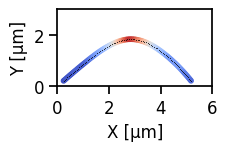

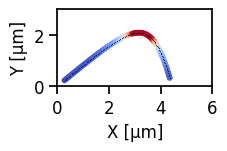

In [56]:
''' looping to get curvature on all spindles and save figure'''

scale=5
#a4_dims = (2,1)
#fig, ax = plt.subplots(figsize=a4_dims)
#sns.set_context("notebook", font_scale=1.5)

for i in range(3,5): ## this is the loop on the Spindles
    if i in Excluded: #Add exclude not well imaged spindles from the analysis
            continue
    data=pd.read_csv('%s%s/sp%s.csv'%(loc,i,i))
    y_path_1=data["Y"]
    x_path_1=data["X"]

    ##rotate the data using the angle between the first and last point
    x_path_2,y_path_2 = reverse(x_path_1,y_path_1)
    angle = np.arctan((y_path_2[0] - y_path_2[99]) / (x_path_2[0] - x_path_2[99]))
    x_path_3,y_path_3 = rotation(x_path_2,y_path_2,angle)
    x_path_4,y_path_4 = translation(x_path_3,y_path_3)
    x_path,y_path = flip(x_path_4,y_path_4)

    radius_1=radius_of_curvature_open(x_path, y_path, scale)[0]


    #########################################################
    #### Remove the first and last point of the spindle (2*scale)
    ###############So that radius_1 and x_path, y_path have same length ########
    # Input list initialization
    Inputx = x_path
    Inputy = y_path

    # list of length in which we have to split
    length_to_split = [scale, 100-2*scale, scale]

    # Using islice
    Outputx = [Inputx[x - y: x] for x, y in zip(accumulate(length_to_split), length_to_split)][1]
    Outputy = [Inputy[x - y: x] for x, y in zip(accumulate(length_to_split), length_to_split)][1]

    my_array = np.asarray(radius_1)

    # Figures position
    a4_dims = (2,1)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.set_context("notebook", font_scale=1.5)


    #color map options : bwr, coolwarm
    #plt.scatter(Outputx,Outputy,marker='o',c=(my_array-minC)/(maxC-minC),cmap=plt.cm.YlOrRd, vmin=0, vmax=0.5,s=10,alpha=1)
    plt.scatter(Outputx,Outputy,marker='o',c=(my_array-minC)/(maxC-minC),cmap=plt.cm.coolwarm, vmin=0, vmax=0.5,s=10,alpha=1)
    plt.scatter(Outputx,Outputy,marker='.',s=1,linewidths=0.2,c='k',alpha=1)

    plt.xlabel('X [µm]',fontsize=12)
    plt.ylabel('Y [µm]',fontsize=12)


    # Major ticks, minor ticks for the figures
    x_ticks = np.arange(0, 8, 2)
    y_ticks = np.arange(0,3, 2)

    plt.xlim([0,6])
    plt.ylim([0,3])

    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    plt.xticks(x_ticks)
    plt.yticks(y_ticks)

